In [83]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [84]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [85]:
# max_component_num = 100
# max_bezier_curve_num = 1000

# image_floder = 'CS 3570 Final Project Topic5'

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100)

In [86]:
import numpy as np
from scipy.linalg import lstsq
from scipy.spatial import distance

def compute_arc_length_params(points):
    """
    計算弧長參數化的參數 t_i
    :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
    :return: 弧长参数化后的参数列表 [t0, t1, ..., tn]
    """
    n = len(points)
    dists = [np.linalg.norm(np.array(points[i]) - np.array(points[i-1])) for i in range(1, n)]
    s = [0] + np.cumsum(dists).tolist()
    total_length = s[-1]
    t = [si / total_length for si in s]
    return t

def fit_bezier_curve(points):
    """
    拟合三次贝塞尔曲线
    :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
    :return: 控制点 [(P0x, P0y), (P1x, P1y), (P2x, P2y), (P3x, P3y)]
    """
    points = np.array(points)
    t = compute_arc_length_params(points)
    
    # 设定 P0 和 P3
    P0 = points[0]
    P3 = points[-1]
    
    # 构建矩阵 A 和向量 B
    A = []
    Bx = []
    By = []
    
    for i in range(1, len(points) - 1):
        ti = t[i]
        A.append([3 * (1 - ti)**2 * ti, 3 * (1 - ti) * ti**2])
        Bx.append(points[i, 0] - ((1 - ti)**3 * P0[0] + ti**3 * P3[0]))
        By.append(points[i, 1] - ((1 - ti)**3 * P0[1] + ti**3 * P3[1]))
    
    A = np.array(A)
    Bx = np.array(Bx)
    By = np.array(By)
    
    # 解最小二乘问题
    Px, _, _, _ = lstsq(A, Bx)
    Py, _, _, _ = lstsq(A, By)
    
    P1 = (Px[0], Py[0])
    P2 = (Px[1], Py[1])
    
    return [tuple(P0), P1, P2, tuple(P3)],t

def bezier_curve(t, p0, p1, p2, p3):
    """
    计算贝塞尔曲线上的点
    :param t: 参数t（0到1之间）
    :param p0: 控制点P0
    :param p1: 控制点P1
    :param p2: 控制点P2
    :param p3: 控制点P3
    :return: 贝塞尔曲线上的点
    """
    return (1-t)**3 * p0 + 3*(1-t)**2 * t * p1 + 3*(1-t) * t**2 * p2 + t**3 * p3

def compute_approximation_error(points, control_points, points_t,important_mask,V22):
    if V22:
        """
        计算逼近误差
        依據面積計算
        """
        error_area=np.zeros(important_mask.shape)
        curve_points = []
        
        # 遍历样本点
        for t in points_t:
            curve_point = bezier_curve(t, *control_points)
            curve_points.append(curve_point)
        curve_points.reverse()
        curve_points = np.array(curve_points)
        poly_points = np.concatenate([points,curve_points],0).astype(np.int32)
        cv2.fillPoly(error_area,[poly_points],(1))
        error_area=important_mask*error_area
        # plt.imshow(error_area)
        # plt.show()
        total_error=np.sum(error_area)
        
        return total_error
    else:
        """
        计算逼近误差
        :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
        :param control_points: 控制点列表 [(P0x, P0y), (P1x, P1y), (P2x, P2y), (P3x, P3y)]
        :return: 逼近误差
        """
        total_error = 0
        n = len(points)
        
        # 遍历样本点
        for point, t in zip(points,points_t):
            curve_point = bezier_curve(t, *control_points)
            dist = distance.euclidean(point, curve_point)
            total_error +=dist
        
        return total_error

def fit_bezier_curve_and_error(points,important_mask,V22):
    control_points,points_t = fit_bezier_curve(points)
    loss=compute_approximation_error(points,np.array(control_points),points_t,important_mask,V22)
    return control_points,loss

def mask_to_contours(mask,V21):
    mask = mask.astype(np.uint8)*255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_points = []
    filled_masks_area = []
    filled_masks = []
    for contour in contours:
        filled_mask = np.zeros(mask.shape, dtype=np.uint8)
        cv2.drawContours(filled_mask, [contour], -1, (1), thickness=cv2.FILLED)
        filled_masks.append(filled_mask)
        filled_masks_area.append(np.sum(filled_mask))
        if V21:
            contours_points.append(np.concatenate([contour[:, 0, :],contour[:1, 0, :]],0)+0.5)
        else:
            contours_points.append(np.concatenate([contour[:, 0, :],contour[:1, 0, :]],0))
    return contours_points,filled_masks,filled_masks_area

def split_bezier_curve(ma,mt,max_loss_control_points_set,V22):
    control_points_set_1 = dict()
    t1=max_loss_control_points_set["range"][0]
    t2=mt
    control_points,loss=fit_bezier_curve_and_error(ma["contours_points"][t1:t2],ma["important_mask"],V22)
    control_points_set_1["control_points"]=control_points
    control_points_set_1["loss"]=loss
    control_points_set_1["range"]=[t1,t2]
    control_points_set_2 = dict()
    t1=mt
    t2=max_loss_control_points_set["range"][1]
    control_points,loss=fit_bezier_curve_and_error(ma["contours_points"][t1:t2],ma["important_mask"],V22)
    control_points_set_2["control_points"]=control_points
    control_points_set_2["loss"]=loss
    control_points_set_2["range"]=[t1,t2]
    return control_points_set_1,control_points_set_2,control_points_set_1["loss"]+control_points_set_2["loss"]

In [87]:
def write_svg(filename,sorted_masks,scale,V21):
    with open(filename, 'w') as f:
        f.write('<svg xmlns="http://www.w3.org/2000/svg" width="'+str(scale[3])+'" height="'+str(scale[2])+'" viewbox="0 0 '+str(scale[3])+' '+str(scale[2])+'">\n')
        for ma in sorted_masks:
            control_points_sets = ma["control_points_sets"]
            rgb = ma["color"]
            control_points = control_points_sets[0]["control_points"]
            f.write('<path d="M {:.2f} {:.2f} '.format(control_points[0][0]*scale[1], control_points[0][1]*scale[0]))
            for control_points_set in control_points_sets:
                control_points = control_points_set["control_points"]
                f.write('C {:.2f} {:.2f}, {:.2f} {:.2f}, {:.2f} {:.2f} '.format(control_points[1][0]*scale[1], control_points[1][1]*scale[0],control_points[2][0]*scale[1], control_points[2][1]*scale[0], control_points[3][0]*scale[1],control_points[3][1]*scale[0]))
            if V21:
                f.write('Z" fill="rgb('+str(rgb[0])+','+str(rgb[1])+','+str(rgb[2])+')" stroke="rgb('+str(rgb[0])+','+str(rgb[1])+','+str(rgb[2])+')" stroke-width="1" />\n')
            else:
                f.write('Z" fill="rgb('+str(rgb[0])+','+str(rgb[1])+','+str(rgb[2])+')" />\n')
        f.write('</svg>')

In [88]:
def SAMVGV1(image_path,max_component_num,max_bezier_curve_num,V21=True,V22=False,V23=False,V31=True,V32=False,Vis=100000):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    scale = [1,1,image.shape[0],image.shape[1]]
    if image.shape[0]*image.shape[1]>1024*1024:
        scale = [image.shape[0]/1024,image.shape[1]/1024,image.shape[0],image.shape[1]]
        image = cv2.resize(image, (1024, 1024))
    masks = mask_generator.generate(image)
    m=np.ones(image.shape[0:2])
    # 找輪廓
    contours_points,filled_masks,filled_masks_area=mask_to_contours(m,V21)
    ma = dict()
    ma["contours_points"] = contours_points[0]
    ma["filled_mask"] = filled_masks[0]
    ma["filled_mask_area"] = filled_masks_area[0]
    new_masks=[ma]
    for i in range(len(masks)):
        m = masks[i]['segmentation']
        contours_points,filled_masks,filled_masks_area=mask_to_contours(m,V21)
        for i in range(len(contours_points)):
            ma = dict()
            ma["contours_points"] = contours_points[i]
            ma["filled_mask"] = filled_masks[i]
            ma["filled_mask_area"] = filled_masks_area[i]
            if len(ma["contours_points"])>=4:
                new_masks.append(ma)
    sorted_masks = sorted(new_masks, key=(lambda x: x['filled_mask_area']), reverse=True)[:max_component_num]
    sorted_masks.reverse()

    # important_mask
    important_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
    for i,ma in enumerate(sorted_masks):
        sorted_masks[i]["important_mask"] = important_mask.copy()
        important_mask = important_mask*(1-sorted_masks[i]["filled_mask"])
        # plt.imshow(important_mask)
        # plt.show()
    
    # 優化bezier_curve，初始化，每人一條
    use_bezier_curve_num = 0
    for ma in sorted_masks:
        control_points,loss=fit_bezier_curve_and_error(ma["contours_points"],ma["important_mask"],V22)
        control_points_set = dict()
        control_points_set["control_points"]=control_points
        control_points_set["loss"]=loss
        control_points_set["range"]=[0,len(ma["contours_points"])-1]
        ma["control_points_sets"]=[control_points_set]
        use_bezier_curve_num+=1
        if use_bezier_curve_num>=max_bezier_curve_num:
            break
    if V32:
        # 基於curve重算fillmask
        for i1,ma in enumerate(sorted_masks):
            bezier_curve_conuter = []
            for i2,control_points_set in enumerate(ma["control_points_sets"]):
                curve_sample_num=control_points_set["range"][1]-control_points_set["range"][0]+1
                ts=np.linspace(0, 1, curve_sample_num)
                for t in ts:
                    curve_point = bezier_curve(t, *np.array(control_points_set["control_points"]))
                    bezier_curve_conuter.append(curve_point)
            bezier_curve_conuter = np.array(bezier_curve_conuter).astype(np.int32)
            bezier_curve_area = np.zeros(sorted_masks[0]["filled_mask"].shape)
            sorted_masks[i1]["filled_mask"] = cv2.fillPoly(bezier_curve_area,[bezier_curve_conuter],(1))

    if V32:
        # 重算important_mask
        important_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
        for i,ma in enumerate(sorted_masks):
            sorted_masks[i]["important_mask"] = important_mask.copy()
            important_mask = important_mask*(1-sorted_masks[i]["filled_mask"])
            # plt.imshow(important_mask)
            # plt.show()

    # 優化bezier_curve
    while use_bezier_curve_num<max_bezier_curve_num:
        use_bezier_curve_num+=1
        max_loss_control_points_set = sorted_masks[0]["control_points_sets"][0]
        max_loss_ma_index = 0
        max_loss_ma_control_points_sets_index = 0
        for i1,ma in enumerate(sorted_masks):
            for i2,control_points_set in enumerate(ma["control_points_sets"]):
                if control_points_set["loss"]>max_loss_control_points_set["loss"]:
                    max_loss_control_points_set = control_points_set
                    max_loss_ma_index = i1
                    max_loss_ma_control_points_sets_index = i2
        if max_loss_control_points_set["range"][1]-max_loss_control_points_set["range"][0]<8:
            break
        ma = sorted_masks[max_loss_ma_index]
        sorted_masks[max_loss_ma_index]["control_points_sets"].pop(max_loss_ma_control_points_sets_index)
        #2log search
        tmin = max_loss_control_points_set["range"][0]+4
        tmax = max_loss_control_points_set["range"][1]-4
        tmid=int((tmin+tmax)//2)
        trange = int((tmax-tmin)//4)
        control_points_set_1,control_points_set_2,mtloss=split_bezier_curve(ma,tmid,max_loss_control_points_set,V22)
        if V23:
            while trange>=1:
                Lcontrol_points_set_1,Lcontrol_points_set_2,Lmtloss=split_bezier_curve(ma,tmid-trange,max_loss_control_points_set,V22)
                Rcontrol_points_set_1,Rcontrol_points_set_2,Rmtloss=split_bezier_curve(ma,tmid+trange,max_loss_control_points_set,V22)
                if Lmtloss<mtloss:
                    control_points_set_1 = Lcontrol_points_set_1
                    control_points_set_2 = Lcontrol_points_set_2
                    mtloss = Lmtloss
                    tmid = tmid-trange
                if Rmtloss<mtloss:
                    control_points_set_1 = Rcontrol_points_set_1
                    control_points_set_2 = Rcontrol_points_set_2
                    mtloss = Rmtloss
                    tmid = tmid+trange
                trange = int(trange//2)

        ma["control_points_sets"].insert(max_loss_ma_control_points_sets_index,control_points_set_1)
        ma["control_points_sets"].insert(max_loss_ma_control_points_sets_index+1,control_points_set_2)
        if V32:
            #重算filled_mask
            bezier_curve_conuter = []
            for i2,control_points_set in enumerate(ma["control_points_sets"]):
                curve_sample_num=control_points_set["range"][1]-control_points_set["range"][0]+1
                ts=np.linspace(0, 1, curve_sample_num)
                for t in ts:
                    curve_point = bezier_curve(t, *np.array(control_points_set["control_points"]))
                    bezier_curve_conuter.append(curve_point)
            bezier_curve_conuter = np.array(bezier_curve_conuter).astype(np.int32)
            bezier_curve_area = np.zeros(sorted_masks[0]["filled_mask"].shape)
            sorted_masks[max_loss_ma_index]["filled_mask"] = cv2.fillPoly(bezier_curve_area,[bezier_curve_conuter],(1))
        
        if V32:
            # 重算important_mask
            important_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
            for i,ma in enumerate(sorted_masks):
                sorted_masks[i]["important_mask"] = important_mask.copy()
                important_mask = important_mask*(1-sorted_masks[i]["filled_mask"])
                # plt.imshow(important_mask)
                # plt.show()
        
        if use_bezier_curve_num%Vis==0:
            
            # 決定顏色
            if V31:
                for i1,ma in enumerate(sorted_masks):
                    bezier_curve_conuter = []
                    for i2,control_points_set in enumerate(ma["control_points_sets"]):
                        curve_sample_num=control_points_set["range"][1]-control_points_set["range"][0]+1
                        ts=np.linspace(0, 1, curve_sample_num)
                        for t in ts:
                            curve_point = bezier_curve(t, *np.array(control_points_set["control_points"]))
                            bezier_curve_conuter.append(curve_point)
                    bezier_curve_conuter = np.array(bezier_curve_conuter).astype(np.int32)
                    bezier_curve_area = np.zeros(sorted_masks[0]["filled_mask"].shape)
                    sorted_masks[i1]["filled_mask"] = cv2.fillPoly(bezier_curve_area,[bezier_curve_conuter],(1))
            
            image_color_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
            for i,ma in enumerate(sorted_masks):
                tm = image_color_mask*ma["filled_mask"]
                sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)
                image_color_mask = image_color_mask * (1-ma["filled_mask"])
            sorted_masks.reverse()
            write_svg('SVG_'+image_path.split('.')[0]+'-'+str(use_bezier_curve_num)+'.svg', sorted_masks,scale,V21)
        
    print(image_path,"\nuse_bezier_curve_num :",use_bezier_curve_num,"\ncomponent_num :",len(sorted_masks))
    
    # 決定顏色
    if V31:
        for i1,ma in enumerate(sorted_masks):
            bezier_curve_conuter = []
            for i2,control_points_set in enumerate(ma["control_points_sets"]):
                curve_sample_num=control_points_set["range"][1]-control_points_set["range"][0]+1
                ts=np.linspace(0, 1, curve_sample_num)
                for t in ts:
                    curve_point = bezier_curve(t, *np.array(control_points_set["control_points"]))
                    bezier_curve_conuter.append(curve_point)
            bezier_curve_conuter = np.array(bezier_curve_conuter).astype(np.int32)
            bezier_curve_area = np.zeros(sorted_masks[0]["filled_mask"].shape)
            sorted_masks[i1]["filled_mask"] = cv2.fillPoly(bezier_curve_area,[bezier_curve_conuter],(1))
    
    image_color_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
    for i,ma in enumerate(sorted_masks):
        tm = image_color_mask*ma["filled_mask"]
        sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)
        image_color_mask = image_color_mask * (1-ma["filled_mask"])
    sorted_masks.reverse()
    write_svg('SVG_'+image_path.split('.')[0]+'.svg', sorted_masks,scale,V21)

In [89]:
#evaluation
def calculate_mse(image1, image2):
    image1 = cv2.imread(image1)
    image2 = cv2.imread(image2)
    # Ensure images are the same shape
    if image1.size != image2.size:
        raise ValueError("Images must have the same dimensions for MSE calculation")
    


    
    # Compute MSE
    mse = np.mean((image1 - image2) ** 2)
    return mse


128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 40 
component_num : 29


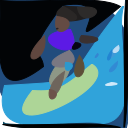

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 69.69333902994792
128\emoji_u1f3e7.png 
use_bezier_curve_num : 40 
component_num : 14


C:\Users\a5658\AppData\Local\Temp\ipykernel_20316\263822590.py:178: RuntimeWarning: invalid value encountered in divide
  sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)


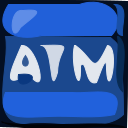

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 55.01678466796875
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 40 
component_num : 28


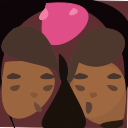

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 82.49458821614583
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 40 
component_num : 31


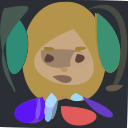

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 106.15486653645833
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 21


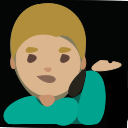

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 44.962666829427086
128\emoji_u1f4b5.png 
use_bezier_curve_num : 40 
component_num : 14


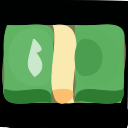

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 27.539164225260418
128\emoji_u1f58a.png 
use_bezier_curve_num : 40 
component_num : 16


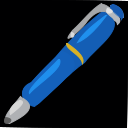

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 15.758544921875
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 40 
component_num : 23


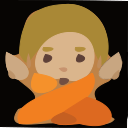

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 48.124796549479164
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 23


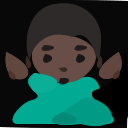

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 60.368387858072914
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 21


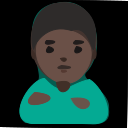

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 29.5701904296875
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 40 
component_num : 19


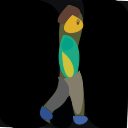

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 16.810078938802082
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 40 
component_num : 23


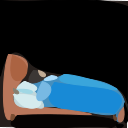

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 25.118245442708332
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 40 
component_num : 15


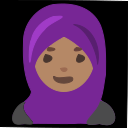

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 38.590413411458336
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 40 
component_num : 33


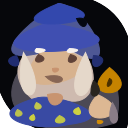

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 73.75978597005208
128\emoji_u1f9ea.png 
use_bezier_curve_num : 40 
component_num : 18


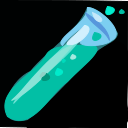

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 13.384867350260416
128 Total MSE: 707.3467203776044
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 80 
component_num : 29


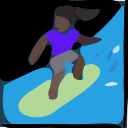

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 63.451314290364586
128\emoji_u1f3e7.png 
use_bezier_curve_num : 80 
component_num : 14


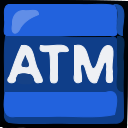

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 35.638387044270836
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 80 
component_num : 28


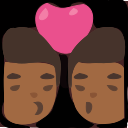

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 32.777933756510414
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 80 
component_num : 31


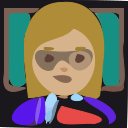

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 76.81402587890625
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 21


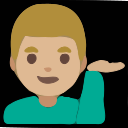

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 27.099629720052082
128\emoji_u1f4b5.png 
use_bezier_curve_num : 80 
component_num : 14


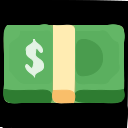

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 25.382425944010418
128\emoji_u1f58a.png 
use_bezier_curve_num : 80 
component_num : 16


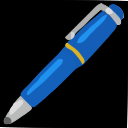

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 12.86553955078125
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 80 
component_num : 23


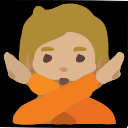

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 28.90679931640625
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 23


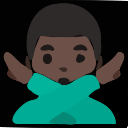

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 27.929931640625
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 21


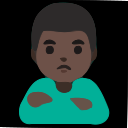

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 22.115397135416668
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 80 
component_num : 19


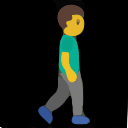

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 8.952168782552084
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 80 
component_num : 23


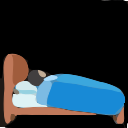

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 12.70977783203125
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 80 
component_num : 15


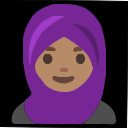

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 35.43536376953125
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 80 
component_num : 33


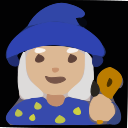

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 42.197428385416664
128\emoji_u1f9ea.png 
use_bezier_curve_num : 80 
component_num : 18


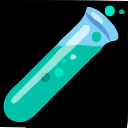

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 9.209940592447916
128 Total MSE: 461.486063639323
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 120 
component_num : 29


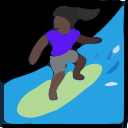

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 58.876973470052086
128\emoji_u1f3e7.png 
use_bezier_curve_num : 120 
component_num : 14


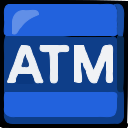

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 30.831339518229168
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 120 
component_num : 28


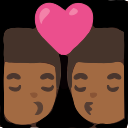

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 28.539591471354168
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 120 
component_num : 31


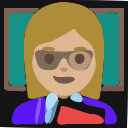

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 79.93892415364583
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 21


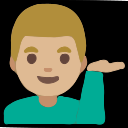

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 25.9652099609375
128\emoji_u1f4b5.png 
use_bezier_curve_num : 120 
component_num : 14


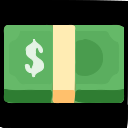

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 23.3865966796875
128\emoji_u1f58a.png 
use_bezier_curve_num : 120 
component_num : 16


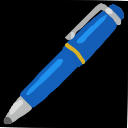

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 12.968851725260416
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 120 
component_num : 23


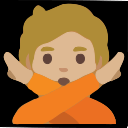

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 24.137349446614582
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 23


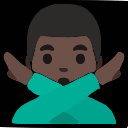

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 26.151346842447918
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 21


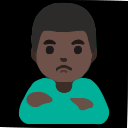

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 20.9752197265625
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 120 
component_num : 19


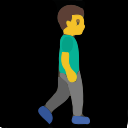

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 8.116800944010416
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 120 
component_num : 23


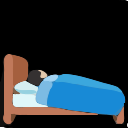

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 8.83087158203125
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 120 
component_num : 15


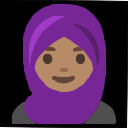

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 32.531270345052086
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 120 
component_num : 33


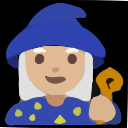

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 30.252217610677082
128\emoji_u1f9ea.png 
use_bezier_curve_num : 120 
component_num : 18


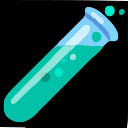

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 8.306681315104166
128 Total MSE: 419.8092447916667
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 160 
component_num : 29


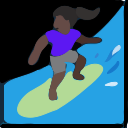

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 57.50634765625
128\emoji_u1f3e7.png 
use_bezier_curve_num : 160 
component_num : 14


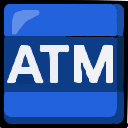

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 29.560994466145832
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 160 
component_num : 28


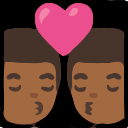

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 26.470723470052082
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 160 
component_num : 31


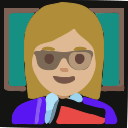

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 73.93391927083333
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 21


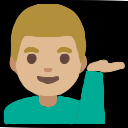

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 25.300882975260418
128\emoji_u1f4b5.png 
use_bezier_curve_num : 160 
component_num : 14


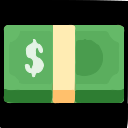

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 24.335795084635418
128\emoji_u1f58a.png 
use_bezier_curve_num : 127 
component_num : 16


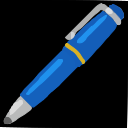

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 13.030680338541666
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 160 
component_num : 23


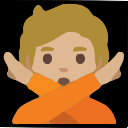

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 23.6885986328125
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 23


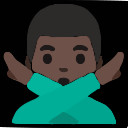

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 25.695271809895832
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 21


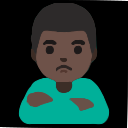

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 20.258402506510418
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 160 
component_num : 19


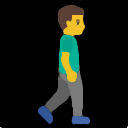

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 7.597900390625
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 160 
component_num : 23


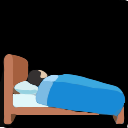

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 9.531107584635416
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 160 
component_num : 15


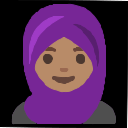

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 32.4344482421875
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 160 
component_num : 33


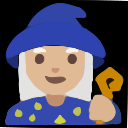

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 27.523946126302082
128\emoji_u1f9ea.png 
use_bezier_curve_num : 160 
component_num : 18


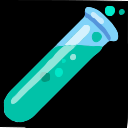

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 7.762471516927083
128 Total MSE: 404.63149007161456
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 200 
component_num : 29


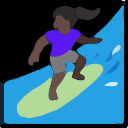

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 56.577006022135414
128\emoji_u1f3e7.png 
use_bezier_curve_num : 166 
component_num : 14


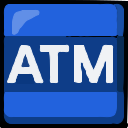

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 29.5247802734375
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 200 
component_num : 28


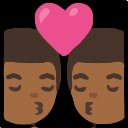

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 25.412556966145832
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 200 
component_num : 31


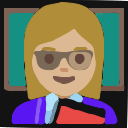

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 69.78228759765625
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 21


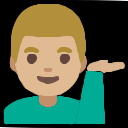

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 25.277994791666668
128\emoji_u1f4b5.png 
use_bezier_curve_num : 177 
component_num : 14


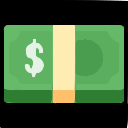

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 24.242594401041668
128\emoji_u1f58a.png 
use_bezier_curve_num : 127 
component_num : 16


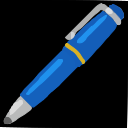

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 13.030680338541666
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 200 
component_num : 23


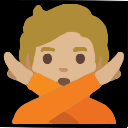

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 23.486409505208332
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 23


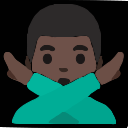

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 25.50103759765625
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 21


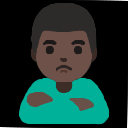

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 19.668558756510418
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 187 
component_num : 19


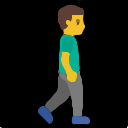

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 7.334716796875
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 200 
component_num : 23


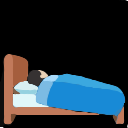

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 9.65655517578125
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 170 
component_num : 15


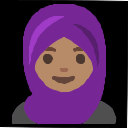

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 32.42352294921875
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 200 
component_num : 33


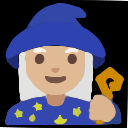

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 26.654500325520832
128\emoji_u1f9ea.png 
use_bezier_curve_num : 187 
component_num : 18


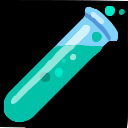

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 7.6409912109375
128 Total MSE: 396.2141927083333
909.6613967418671


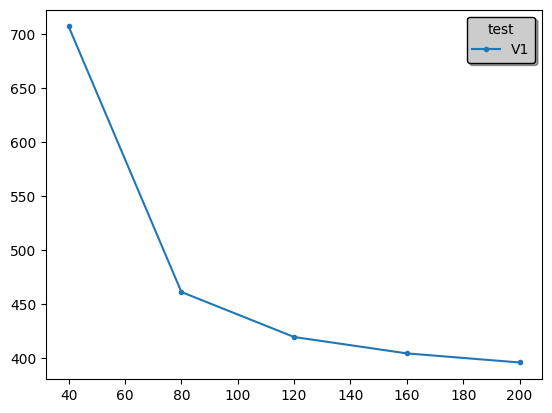

In [90]:
max_component_num = 40
max_bezier_curve_nums = [40,80,120,160,200]

image_floder = '128'

import os

gtkbin = r'C:\Program Files\GTK3-Runtime Win64\bin'
add_dll_dir = getattr(os, 'add_dll_directory', None)
if callable(add_dll_dir):
    add_dll_dir(gtkbin)
else:
    os.environ['PATH'] = os.pathsep.join((gtkbin, os.environ['PATH']))

import glob
import random
import time
from cairosvg import svg2png
from IPython.display import display, SVG


image_paths=glob.glob(image_floder+"/*.jpg")+glob.glob(image_floder+"/*.png")

tmsess = dict()

# random.shuffle(image_paths)
def Test(V21=False,V22=False,V23=False,V31=False,V32=False,labelname="V"):
    ti=time.time()
    tmses=[]
    for max_bezier_curve_num in max_bezier_curve_nums:
        tmse=0

        for image_path in image_paths:
            SAMVGV1(image_path,max_component_num,max_bezier_curve_num,V21,V22,V23,V31,V32)

            #convert SVG to PNG
            svg_path = 'SVG_' + image_path.split('.')[0]+'.svg'
            write_path = 'SVG2PNG_' + image_path.split('.')[0] + '.png'
            # Display an SVG file directly from its path
            display(SVG(filename=svg_path))
            svg2png(url=svg_path, write_to=write_path, unsafe=True)
            mse=calculate_mse(image_path, write_path)
            tmse+=mse
            print(image_path +" vs " + write_path + ": " + str(mse))
        print(image_floder+" Total MSE:",tmse)
        tmses.append(tmse)
    print(time.time()-ti)
    plt.plot(max_bezier_curve_nums,tmses,'.-',label=labelname)
    tmsess[labelname] = tmses
    
Test(V21=True,V31=True,labelname="V1")
plt.legend(
    loc='best',
    fontsize=10,
    shadow=True,
    facecolor='#ccc',
    edgecolor='#000',
    title='test',
    title_fontsize=10)
plt.show()


128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 40 
component_num : 29


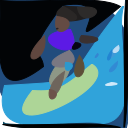

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 69.69333902994792
128\emoji_u1f3e7.png 
use_bezier_curve_num : 40 
component_num : 14


C:\Users\a5658\AppData\Local\Temp\ipykernel_20316\263822590.py:178: RuntimeWarning: invalid value encountered in divide
  sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)


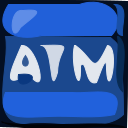

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 55.01678466796875
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 40 
component_num : 28


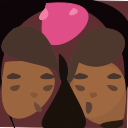

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 82.49458821614583
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 40 
component_num : 31


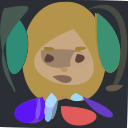

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 106.15486653645833
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 21


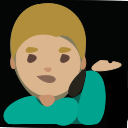

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 44.962666829427086
128\emoji_u1f4b5.png 
use_bezier_curve_num : 40 
component_num : 14


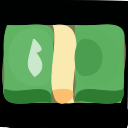

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 27.539164225260418
128\emoji_u1f58a.png 
use_bezier_curve_num : 40 
component_num : 16


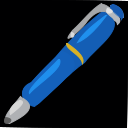

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 15.758544921875
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 40 
component_num : 23


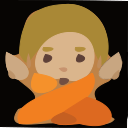

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 48.124796549479164
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 23


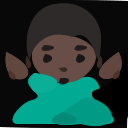

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 60.368387858072914
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 21


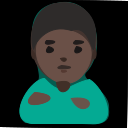

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 29.5701904296875
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 40 
component_num : 19


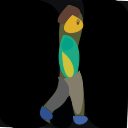

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 16.810078938802082
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 40 
component_num : 23


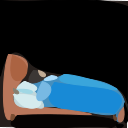

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 25.118245442708332
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 40 
component_num : 15


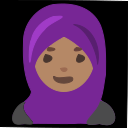

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 38.590413411458336
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 40 
component_num : 33


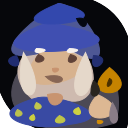

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 73.75978597005208
128\emoji_u1f9ea.png 
use_bezier_curve_num : 40 
component_num : 18


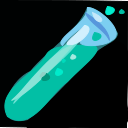

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 13.384867350260416
128 Total MSE: 707.3467203776044
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 80 
component_num : 29


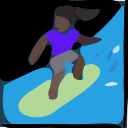

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 63.451314290364586
128\emoji_u1f3e7.png 
use_bezier_curve_num : 80 
component_num : 14


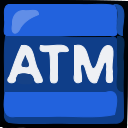

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 35.638387044270836
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 80 
component_num : 28


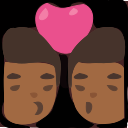

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 32.777933756510414
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 80 
component_num : 31


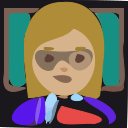

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 76.81402587890625
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 21


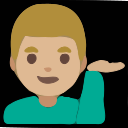

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 27.099629720052082
128\emoji_u1f4b5.png 
use_bezier_curve_num : 80 
component_num : 14


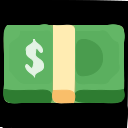

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 25.382425944010418
128\emoji_u1f58a.png 
use_bezier_curve_num : 80 
component_num : 16


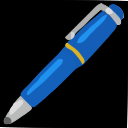

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 12.86553955078125
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 80 
component_num : 23


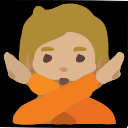

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 28.90679931640625
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 23


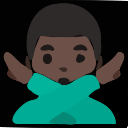

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 27.929931640625
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 21


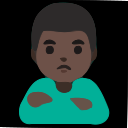

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 22.115397135416668
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 80 
component_num : 19


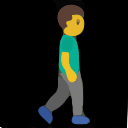

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 8.952168782552084
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 80 
component_num : 23


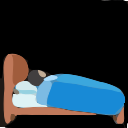

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 12.70977783203125
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 80 
component_num : 15


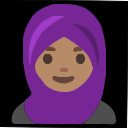

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 35.43536376953125
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 80 
component_num : 33


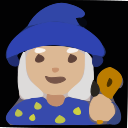

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 42.197428385416664
128\emoji_u1f9ea.png 
use_bezier_curve_num : 80 
component_num : 18


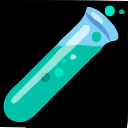

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 9.209940592447916
128 Total MSE: 461.486063639323
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 120 
component_num : 29


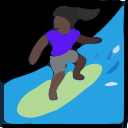

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 58.876973470052086
128\emoji_u1f3e7.png 
use_bezier_curve_num : 120 
component_num : 14


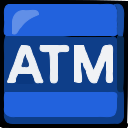

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 30.831339518229168
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 120 
component_num : 28


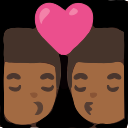

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 28.539591471354168
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 120 
component_num : 31


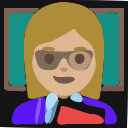

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 79.93892415364583
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 21


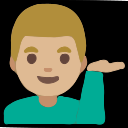

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 25.9652099609375
128\emoji_u1f4b5.png 
use_bezier_curve_num : 120 
component_num : 14


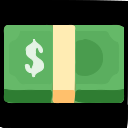

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 23.3865966796875
128\emoji_u1f58a.png 
use_bezier_curve_num : 120 
component_num : 16


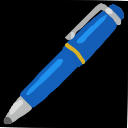

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 12.968851725260416
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 120 
component_num : 23


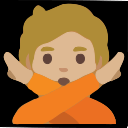

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 24.137349446614582
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 23


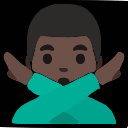

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 26.151346842447918
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 21


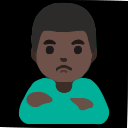

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 20.9752197265625
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 120 
component_num : 19


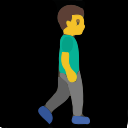

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 8.116800944010416
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 120 
component_num : 23


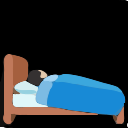

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 8.83087158203125
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 120 
component_num : 15


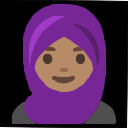

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 32.531270345052086
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 120 
component_num : 33


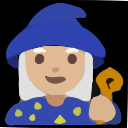

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 30.252217610677082
128\emoji_u1f9ea.png 
use_bezier_curve_num : 120 
component_num : 18


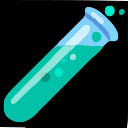

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 8.306681315104166
128 Total MSE: 419.8092447916667
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 160 
component_num : 29


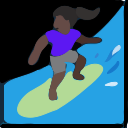

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 57.50634765625
128\emoji_u1f3e7.png 
use_bezier_curve_num : 160 
component_num : 14


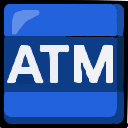

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 29.560994466145832
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 160 
component_num : 28


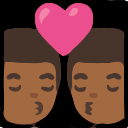

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 26.470723470052082
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 160 
component_num : 31


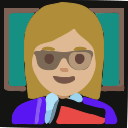

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 73.93391927083333
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 21


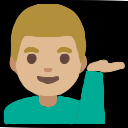

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 25.300882975260418
128\emoji_u1f4b5.png 
use_bezier_curve_num : 160 
component_num : 14


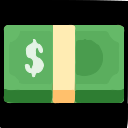

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 24.335795084635418
128\emoji_u1f58a.png 
use_bezier_curve_num : 127 
component_num : 16


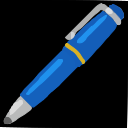

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 13.030680338541666
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 160 
component_num : 23


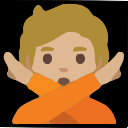

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 23.6885986328125
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 23


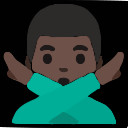

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 25.695271809895832
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 21


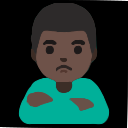

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 20.258402506510418
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 160 
component_num : 19


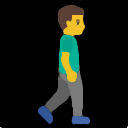

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 7.597900390625
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 160 
component_num : 23


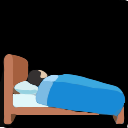

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 9.531107584635416
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 160 
component_num : 15


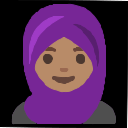

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 32.4344482421875
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 160 
component_num : 33


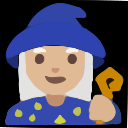

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 27.523946126302082
128\emoji_u1f9ea.png 
use_bezier_curve_num : 160 
component_num : 18


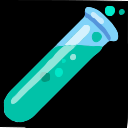

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 7.762471516927083
128 Total MSE: 404.63149007161456
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 200 
component_num : 29


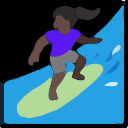

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 56.577006022135414
128\emoji_u1f3e7.png 
use_bezier_curve_num : 166 
component_num : 14


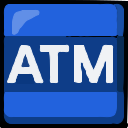

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 29.5247802734375
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 200 
component_num : 28


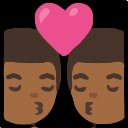

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 25.412556966145832
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 200 
component_num : 31


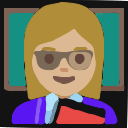

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 69.78228759765625
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 21


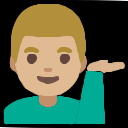

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 25.277994791666668
128\emoji_u1f4b5.png 
use_bezier_curve_num : 177 
component_num : 14


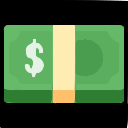

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 24.242594401041668
128\emoji_u1f58a.png 
use_bezier_curve_num : 127 
component_num : 16


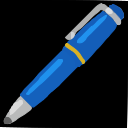

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 13.030680338541666
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 200 
component_num : 23


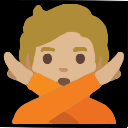

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 23.486409505208332
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 23


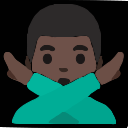

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 25.50103759765625
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 21


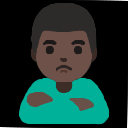

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 19.668558756510418
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 187 
component_num : 19


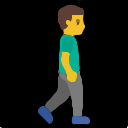

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 7.334716796875
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 200 
component_num : 23


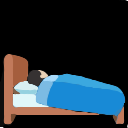

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 9.65655517578125
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 170 
component_num : 15


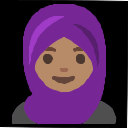

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 32.42352294921875
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 200 
component_num : 33


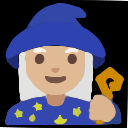

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 26.654500325520832
128\emoji_u1f9ea.png 
use_bezier_curve_num : 187 
component_num : 18


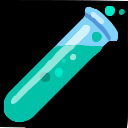

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 7.6409912109375
128 Total MSE: 396.2141927083333
909.6613967418671


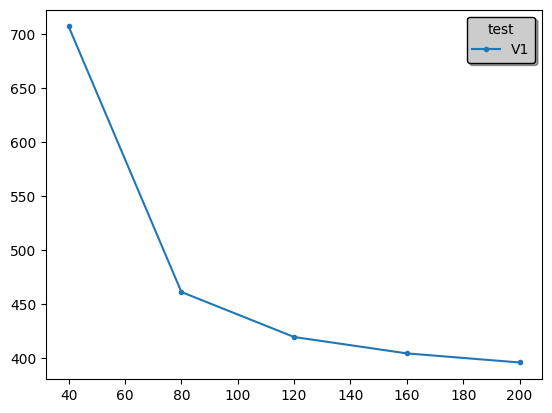

In [ ]:
max_component_num = 40
max_bezier_curve_nums = [40,80,120,160,200]

image_floder = '128'

import os

gtkbin = r'C:\Program Files\GTK3-Runtime Win64\bin'
add_dll_dir = getattr(os, 'add_dll_directory', None)
if callable(add_dll_dir):
    add_dll_dir(gtkbin)
else:
    os.environ['PATH'] = os.pathsep.join((gtkbin, os.environ['PATH']))

import glob
import random
import time
from cairosvg import svg2png
from IPython.display import display, SVG


image_paths=glob.glob(image_floder+"/*.jpg")+glob.glob(image_floder+"/*.png")

tmsess = dict()

# random.shuffle(image_paths)
def Test(V21=False,V22=False,V23=False,V31=False,V32=False,labelname="V"):
    ti=time.time()
    tmses=[]
    for max_bezier_curve_num in max_bezier_curve_nums:
        tmse=0

        for image_path in image_paths:
            SAMVGV1(image_path,max_component_num,max_bezier_curve_num,V21,V22,V23,V31,V32)

            #convert SVG to PNG
            svg_path = 'SVG_' + image_path.split('.')[0]+'.svg'
            write_path = 'SVG2PNG_' + image_path.split('.')[0] + '.png'
            # Display an SVG file directly from its path
            display(SVG(filename=svg_path))
            svg2png(url=svg_path, write_to=write_path, unsafe=True)
            mse=calculate_mse(image_path, write_path)
            tmse+=mse
            print(image_path +" vs " + write_path + ": " + str(mse))
        print(image_floder+" Total MSE:",tmse)
        tmses.append(tmse)
    print(time.time()-ti)
    plt.plot(max_bezier_curve_nums,tmses,'.-',label=labelname)
    tmsess[labelname] = tmses
    
Test(V21=True,V31=True,labelname="V1")
plt.legend(
    loc='best',
    fontsize=10,
    shadow=True,
    facecolor='#ccc',
    edgecolor='#000',
    title='test',
    title_fontsize=10)
plt.show()


128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 40 
component_num : 29


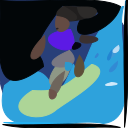

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 73.98295084635417
128\emoji_u1f3e7.png 
use_bezier_curve_num : 40 
component_num : 14


C:\Users\a5658\AppData\Local\Temp\ipykernel_20316\263822590.py:178: RuntimeWarning: invalid value encountered in divide
  sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)


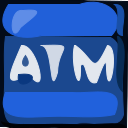

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 56.027262369791664
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 40 
component_num : 28


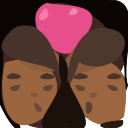

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 69.43076578776042
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 40 
component_num : 31


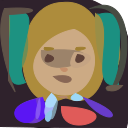

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 90.95450846354167
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 21


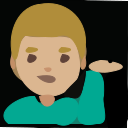

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 42.732340494791664
128\emoji_u1f4b5.png 
use_bezier_curve_num : 40 
component_num : 14


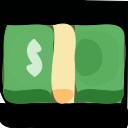

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 32.05731201171875
128\emoji_u1f58a.png 
use_bezier_curve_num : 40 
component_num : 16


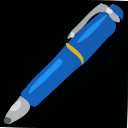

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 16.5457763671875
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 40 
component_num : 23


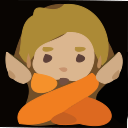

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 47.190694173177086
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 23


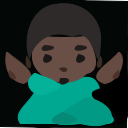

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 46.697062174479164
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 21


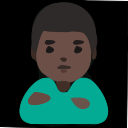

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 26.273844401041668
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 40 
component_num : 19


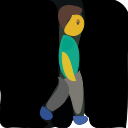

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 15.889811197916666
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 40 
component_num : 23


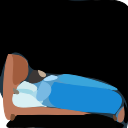

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 18.07244873046875
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 40 
component_num : 15


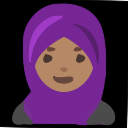

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 38.281005859375
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 40 
component_num : 33


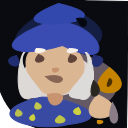

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 74.83365885416667
128\emoji_u1f9ea.png 
use_bezier_curve_num : 40 
component_num : 18


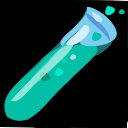

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 13.101216634114584
128 Total MSE: 662.0706583658855
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 80 
component_num : 29


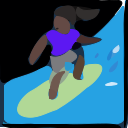

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 61.523173014322914
128\emoji_u1f3e7.png 
use_bezier_curve_num : 80 
component_num : 14


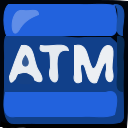

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 51.971923828125
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 80 
component_num : 28


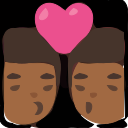

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 32.029073079427086
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 80 
component_num : 31


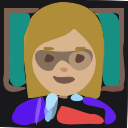

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 81.0052490234375
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 21


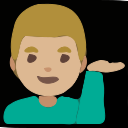

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 29.10821533203125
128\emoji_u1f4b5.png 
use_bezier_curve_num : 80 
component_num : 14


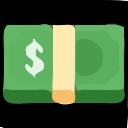

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 26.046122233072918
128\emoji_u1f58a.png 
use_bezier_curve_num : 80 
component_num : 16


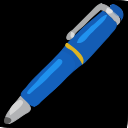

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 14.62451171875
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 80 
component_num : 23


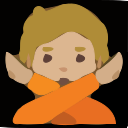

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 33.666910807291664
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 23


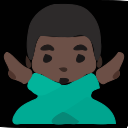

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 28.4156494140625
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 21


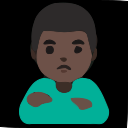

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 21.892557779947918
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 80 
component_num : 19


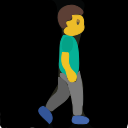

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 10.31964111328125
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 80 
component_num : 23


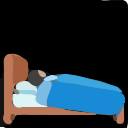

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 13.939066569010416
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 80 
component_num : 15


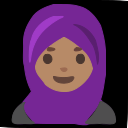

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 35.519999186197914
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 80 
component_num : 33


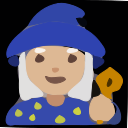

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 34.3687744140625
128\emoji_u1f9ea.png 
use_bezier_curve_num : 80 
component_num : 18


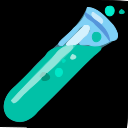

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 9.256184895833334
128 Total MSE: 483.68705240885424
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 120 
component_num : 29


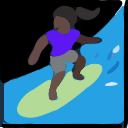

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 57.656758626302086
128\emoji_u1f3e7.png 
use_bezier_curve_num : 120 
component_num : 14


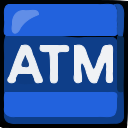

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 32.184122721354164
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 120 
component_num : 28


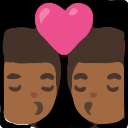

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 29.016743977864582
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 120 
component_num : 31


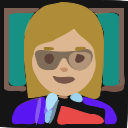

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 87.25004069010417
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 21


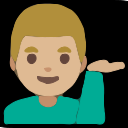

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 26.910481770833332
128\emoji_u1f4b5.png 
use_bezier_curve_num : 120 
component_num : 14


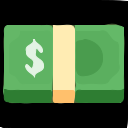

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 23.8101806640625
128\emoji_u1f58a.png 
use_bezier_curve_num : 120 
component_num : 16


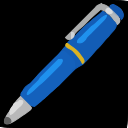

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 13.40704345703125
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 120 
component_num : 23


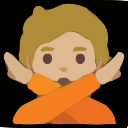

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 25.668599446614582
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 23


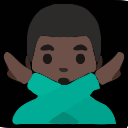

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 27.0606689453125
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 21


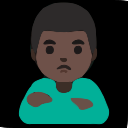

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 21.29327392578125
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 120 
component_num : 19


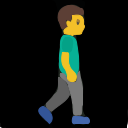

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 8.616373697916666
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 120 
component_num : 23


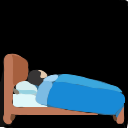

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 12.4166259765625
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 120 
component_num : 15


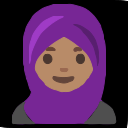

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 35.6610107421875
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 120 
component_num : 33


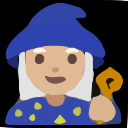

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 29.767313639322918
128\emoji_u1f9ea.png 
use_bezier_curve_num : 120 
component_num : 18


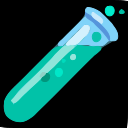

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 8.32928466796875
128 Total MSE: 439.0485229492188
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 160 
component_num : 29


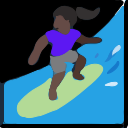

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 57.627298990885414
128\emoji_u1f3e7.png 
use_bezier_curve_num : 160 
component_num : 14


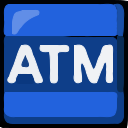

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 31.4892578125
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 160 
component_num : 28


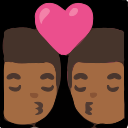

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 26.7557373046875
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 160 
component_num : 31


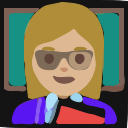

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 78.2220458984375
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 21


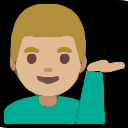

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 26.032511393229168
128\emoji_u1f4b5.png 
use_bezier_curve_num : 160 
component_num : 14


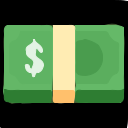

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 24.0760498046875
128\emoji_u1f58a.png 
use_bezier_curve_num : 160 
component_num : 16


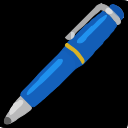

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 12.594584147135416
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 160 
component_num : 23


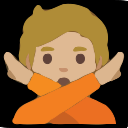

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 24.423299153645832
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 23


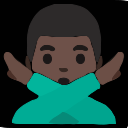

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 26.202494303385418
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 21


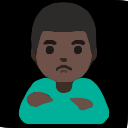

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 20.8172607421875
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 160 
component_num : 19


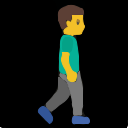

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 7.943562825520833
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 160 
component_num : 23


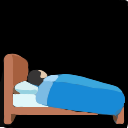

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 11.713765462239584
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 160 
component_num : 15


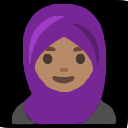

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 35.46929931640625
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 160 
component_num : 33


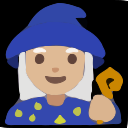

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 27.99993896484375
128\emoji_u1f9ea.png 
use_bezier_curve_num : 160 
component_num : 18


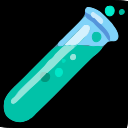

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 8.152933756510416
128 Total MSE: 419.52003987630206
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 200 
component_num : 29


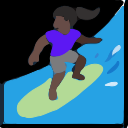

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 56.909586588541664
128\emoji_u1f3e7.png 
use_bezier_curve_num : 200 
component_num : 14


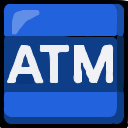

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 29.6171875
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 200 
component_num : 28


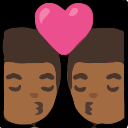

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 26.242329915364582
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 200 
component_num : 31


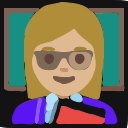

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 72.19449869791667
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 21


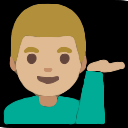

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 25.731343587239582
128\emoji_u1f4b5.png 
use_bezier_curve_num : 200 
component_num : 14


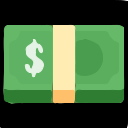

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 25.045511881510418
128\emoji_u1f58a.png 
use_bezier_curve_num : 200 
component_num : 16


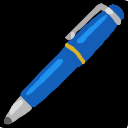

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 11.307718912760416
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 200 
component_num : 23


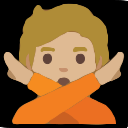

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 24.046040852864582
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 23


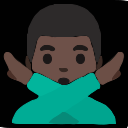

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 26.075785319010418
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 21


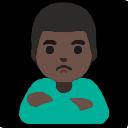

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 20.326924641927082
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 200 
component_num : 19


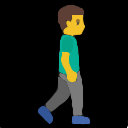

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 7.638427734375
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 200 
component_num : 23


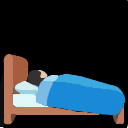

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 9.097798665364584
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 200 
component_num : 15


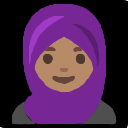

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 32.940653483072914
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 200 
component_num : 33


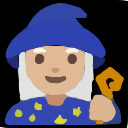

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 27.230875651041668
128\emoji_u1f9ea.png 
use_bezier_curve_num : 200 
component_num : 18


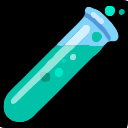

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 7.893310546875
128 Total MSE: 402.29799397786456
909.8467524051666


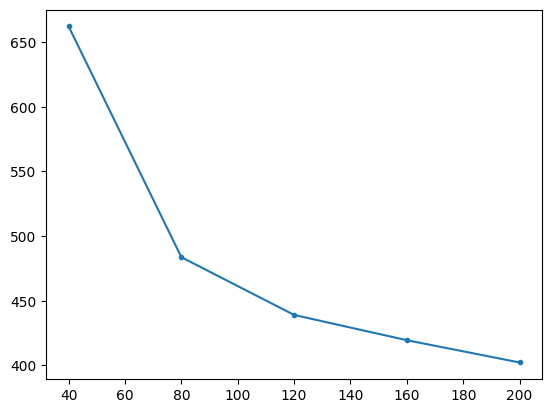

In [91]:
Test(V21=True,V22=True,V31=True,labelname="V22")

128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 40 
component_num : 29


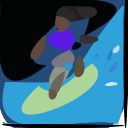

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 72.6832275390625
128\emoji_u1f3e7.png 
use_bezier_curve_num : 40 
component_num : 14


C:\Users\a5658\AppData\Local\Temp\ipykernel_20316\263822590.py:178: RuntimeWarning: invalid value encountered in divide
  sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)


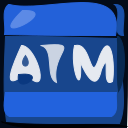

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 75.23594156901042
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 40 
component_num : 28


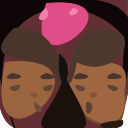

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 85.64945475260417
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 40 
component_num : 31


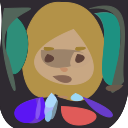

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 100.4520263671875
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 21


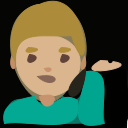

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 42.9793701171875
128\emoji_u1f4b5.png 
use_bezier_curve_num : 40 
component_num : 14


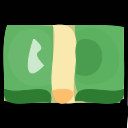

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 26.181844075520832
128\emoji_u1f58a.png 
use_bezier_curve_num : 40 
component_num : 16


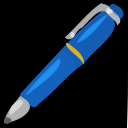

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 15.214070638020834
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 40 
component_num : 23


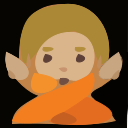

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 47.32574462890625
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 23


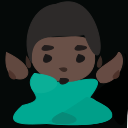

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 56.157674153645836
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 21


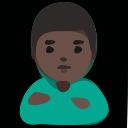

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 29.930908203125
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 40 
component_num : 19


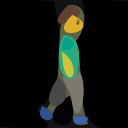

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 19.92596435546875
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 40 
component_num : 23


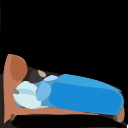

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 18.7366943359375
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 40 
component_num : 15


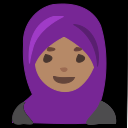

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 37.486592610677086
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 40 
component_num : 33


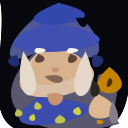

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 92.19852701822917
128\emoji_u1f9ea.png 
use_bezier_curve_num : 40 
component_num : 18


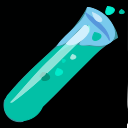

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 14.809041341145834
128 Total MSE: 734.9670817057292
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 80 
component_num : 29


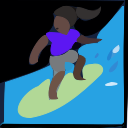

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 61.268656412760414
128\emoji_u1f3e7.png 
use_bezier_curve_num : 80 
component_num : 14


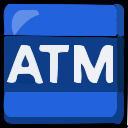

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 33.48919677734375
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 80 
component_num : 28


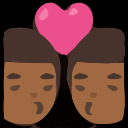

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 32.86846923828125
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 80 
component_num : 31


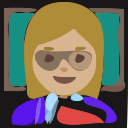

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 75.19205729166667
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 21


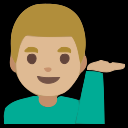

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 26.097819010416668
128\emoji_u1f4b5.png 
use_bezier_curve_num : 80 
component_num : 14


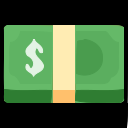

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 23.057393391927082
128\emoji_u1f58a.png 
use_bezier_curve_num : 80 
component_num : 16


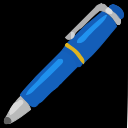

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 13.030741373697916
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 80 
component_num : 23


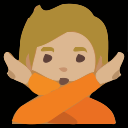

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 27.142191569010418
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 23


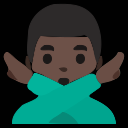

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 26.992472330729168
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 21


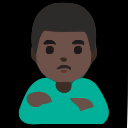

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 21.677937825520832
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 80 
component_num : 19


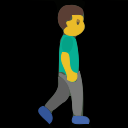

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 9.1815185546875
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 80 
component_num : 23


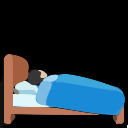

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 9.72149658203125
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 80 
component_num : 15


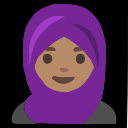

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 33.018575032552086
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 80 
component_num : 33


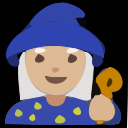

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 33.318562825520836
128\emoji_u1f9ea.png 
use_bezier_curve_num : 80 
component_num : 18


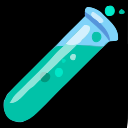

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 8.17877197265625
128 Total MSE: 434.23586018880206
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 120 
component_num : 29


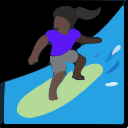

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 57.805928548177086
128\emoji_u1f3e7.png 
use_bezier_curve_num : 120 
component_num : 14


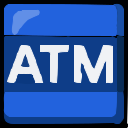

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 29.970682779947918
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 120 
component_num : 28


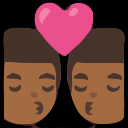

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 27.0806884765625
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 120 
component_num : 31


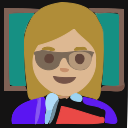

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 73.08135986328125
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 21


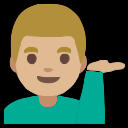

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 25.389607747395832
128\emoji_u1f4b5.png 
use_bezier_curve_num : 120 
component_num : 14


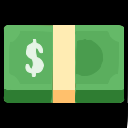

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 23.516133626302082
128\emoji_u1f58a.png 
use_bezier_curve_num : 120 
component_num : 16


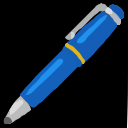

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 12.85845947265625
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 120 
component_num : 23


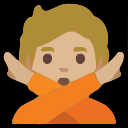

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 24.007548014322918
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 23


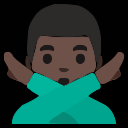

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 25.694661458333332
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 21


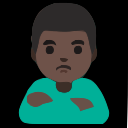

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 21.269002278645832
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 120 
component_num : 19


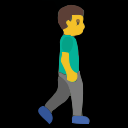

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 7.457865397135417
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 120 
component_num : 23


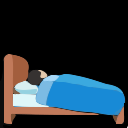

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 10.4197998046875
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 120 
component_num : 15


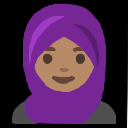

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 32.774617513020836
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 120 
component_num : 33


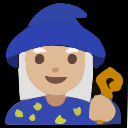

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 29.23968505859375
128\emoji_u1f9ea.png 
use_bezier_curve_num : 120 
component_num : 18


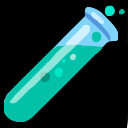

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 7.91656494140625
128 Total MSE: 408.48260498046875
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 160 
component_num : 29


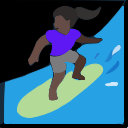

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 56.983723958333336
128\emoji_u1f3e7.png 
use_bezier_curve_num : 149 
component_num : 14


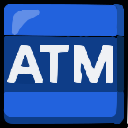

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 30.887654622395832
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 160 
component_num : 28


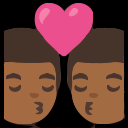

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 25.63861083984375
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 160 
component_num : 31


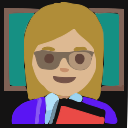

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 71.5382080078125
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 21


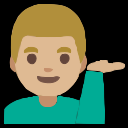

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 25.026326497395832
128\emoji_u1f4b5.png 
use_bezier_curve_num : 120 
component_num : 14


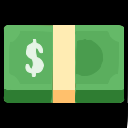

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 23.516133626302082
128\emoji_u1f58a.png 
use_bezier_curve_num : 125 
component_num : 16


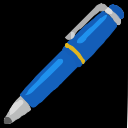

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 13.1507568359375
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 160 
component_num : 23


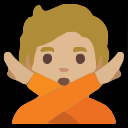

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 23.41143798828125
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 23


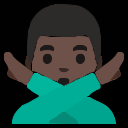

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 25.204142252604168
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 21


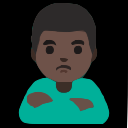

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 20.477091471354168
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 160 
component_num : 19


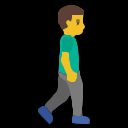

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 7.287109375
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 160 
component_num : 23


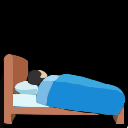

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 9.6737060546875
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 160 
component_num : 15


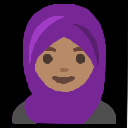

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 32.945699055989586
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 160 
component_num : 33


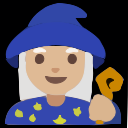

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 27.244160970052082
128\emoji_u1f9ea.png 
use_bezier_curve_num : 160 
component_num : 18


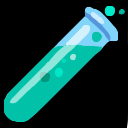

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 7.693339029947917
128 Total MSE: 400.67810058593756
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 200 
component_num : 29


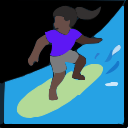

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 55.884236653645836
128\emoji_u1f3e7.png 
use_bezier_curve_num : 149 
component_num : 14


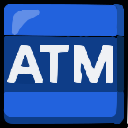

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 30.887654622395832
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 200 
component_num : 28


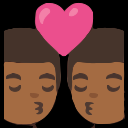

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 24.967244466145832
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 200 
component_num : 31


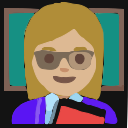

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 69.54337565104167
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 21


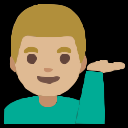

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 24.785990397135418
128\emoji_u1f4b5.png 
use_bezier_curve_num : 120 
component_num : 14


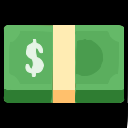

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 23.516133626302082
128\emoji_u1f58a.png 
use_bezier_curve_num : 125 
component_num : 16


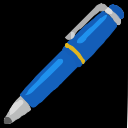

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 13.1507568359375
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 200 
component_num : 23


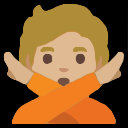

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 23.339640299479168
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 23


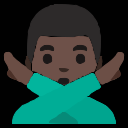

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 25.39227294921875
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 187 
component_num : 21


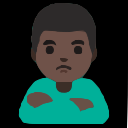

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 20.370564778645832
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 174 
component_num : 19


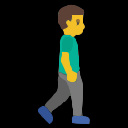

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 7.060831705729167
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 200 
component_num : 23


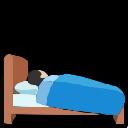

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 9.282063802083334
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 166 
component_num : 15


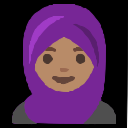

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 32.919392903645836
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 200 
component_num : 33


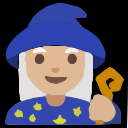

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 26.495564778645832
128\emoji_u1f9ea.png 
use_bezier_curve_num : 160 
component_num : 18


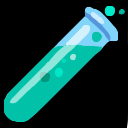

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 7.693339029947917
128 Total MSE: 395.2890625
981.8004243373871


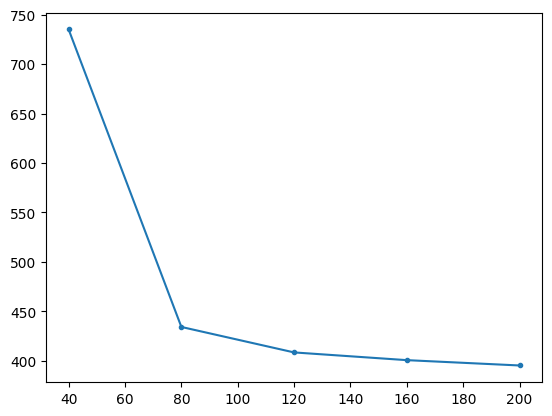

In [92]:
Test(V21=True,V23=True,V31=True,labelname="V23")

128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 40 
component_num : 29


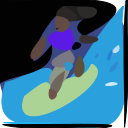

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 65.88680013020833
128\emoji_u1f3e7.png 
use_bezier_curve_num : 40 
component_num : 14


C:\Users\a5658\AppData\Local\Temp\ipykernel_20316\263822590.py:178: RuntimeWarning: invalid value encountered in divide
  sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)


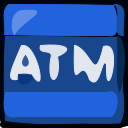

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 76.88755289713542
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 40 
component_num : 28


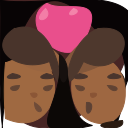

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 55.766357421875
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 40 
component_num : 31


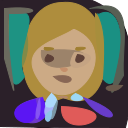

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 78.47922770182292
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 21


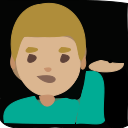

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 37.775410970052086
128\emoji_u1f4b5.png 
use_bezier_curve_num : 40 
component_num : 14


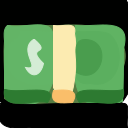

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 29.555745442708332
128\emoji_u1f58a.png 
use_bezier_curve_num : 40 
component_num : 16


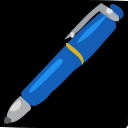

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 16.342549641927082
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 40 
component_num : 23


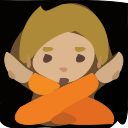

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 41.514607747395836
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 23


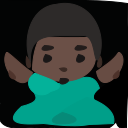

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 38.551900227864586
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 21


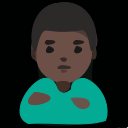

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 26.202250162760418
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 40 
component_num : 19


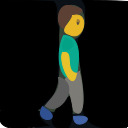

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 13.581685384114584
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 40 
component_num : 23


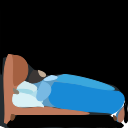

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 14.59307861328125
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 40 
component_num : 15


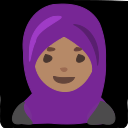

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 37.932779947916664
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 40 
component_num : 33


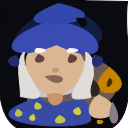

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 71.66143798828125
128\emoji_u1f9ea.png 
use_bezier_curve_num : 40 
component_num : 18


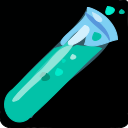

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 12.00469970703125
128 Total MSE: 616.7360839843749
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 80 
component_num : 29


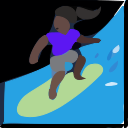

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 57.164591471354164
128\emoji_u1f3e7.png 
use_bezier_curve_num : 80 
component_num : 14


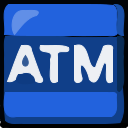

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 35.690348307291664
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 80 
component_num : 28


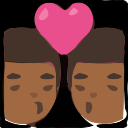

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 31.819071451822918
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 80 
component_num : 31


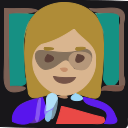

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 69.20576985677083
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 21


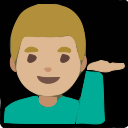

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 27.705891927083332
128\emoji_u1f4b5.png 
use_bezier_curve_num : 80 
component_num : 14


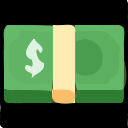

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 22.25390625
128\emoji_u1f58a.png 
use_bezier_curve_num : 80 
component_num : 16


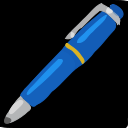

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 14.57550048828125
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 80 
component_num : 23


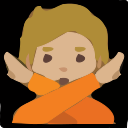

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 29.40228271484375
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 23


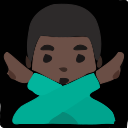

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 28.696675618489582
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 21


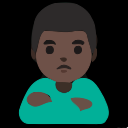

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 21.615315755208332
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 80 
component_num : 19


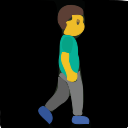

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 8.901387532552084
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 80 
component_num : 23


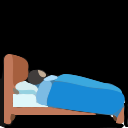

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 11.06207275390625
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 80 
component_num : 15


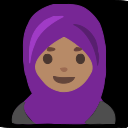

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 36.302775065104164
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 80 
component_num : 33


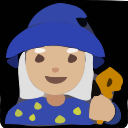

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 33.273640950520836
128\emoji_u1f9ea.png 
use_bezier_curve_num : 80 
component_num : 18


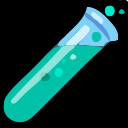

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 8.922322591145834
128 Total MSE: 436.5915527343749
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 120 
component_num : 29


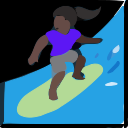

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 57.26953125
128\emoji_u1f3e7.png 
use_bezier_curve_num : 120 
component_num : 14


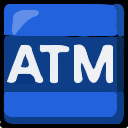

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 32.108683268229164
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 120 
component_num : 28


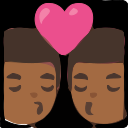

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 28.20379638671875
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 120 
component_num : 31


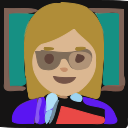

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 81.99623616536458
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 21


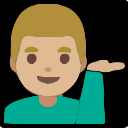

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 25.949686686197918
128\emoji_u1f4b5.png 
use_bezier_curve_num : 120 
component_num : 14


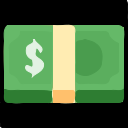

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 22.838155110677082
128\emoji_u1f58a.png 
use_bezier_curve_num : 120 
component_num : 16


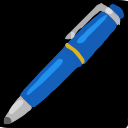

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 13.125956217447916
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 120 
component_num : 23


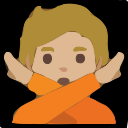

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 25.16015625
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 23


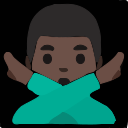

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 26.776326497395832
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 21


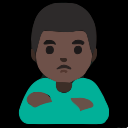

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 21.124043782552082
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 120 
component_num : 19


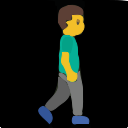

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 8.486002604166666
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 120 
component_num : 23


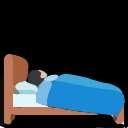

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 11.052408854166666
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 120 
component_num : 15


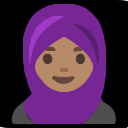

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 35.424906412760414
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 120 
component_num : 33


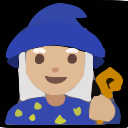

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 29.2806396484375
128\emoji_u1f9ea.png 
use_bezier_curve_num : 120 
component_num : 18


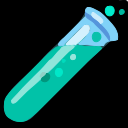

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 8.448262532552084
128 Total MSE: 427.2447916666667
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 160 
component_num : 29


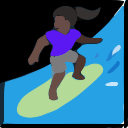

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 57.182210286458336
128\emoji_u1f3e7.png 
use_bezier_curve_num : 160 
component_num : 14


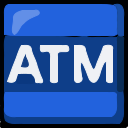

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 30.631937662760418
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 160 
component_num : 28


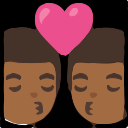

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 26.803181966145832
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 160 
component_num : 31


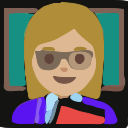

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 76.03631591796875
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 21


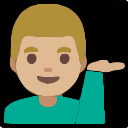

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 25.580301920572918
128\emoji_u1f4b5.png 
use_bezier_curve_num : 160 
component_num : 14


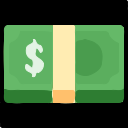

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 23.924540201822918
128\emoji_u1f58a.png 
use_bezier_curve_num : 160 
component_num : 16


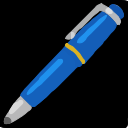

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 12.8804931640625
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 160 
component_num : 23


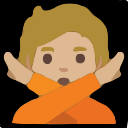

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 24.2154541015625
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 23


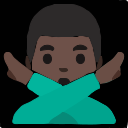

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 26.07684326171875
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 21


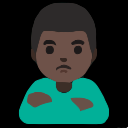

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 20.757609049479168
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 160 
component_num : 19


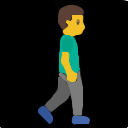

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 7.956522623697917
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 160 
component_num : 23


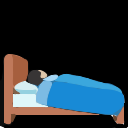

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 11.1387939453125
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 160 
component_num : 15


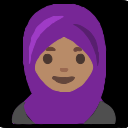

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 32.931640625
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 160 
component_num : 33


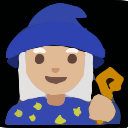

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 27.26129150390625
128\emoji_u1f9ea.png 
use_bezier_curve_num : 160 
component_num : 18


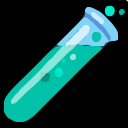

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 8.353841145833334
128 Total MSE: 411.73097737630206
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 200 
component_num : 29


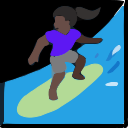

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 55.241800944010414
128\emoji_u1f3e7.png 
use_bezier_curve_num : 200 
component_num : 14


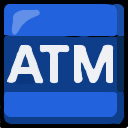

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 30.95513916015625
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 200 
component_num : 28


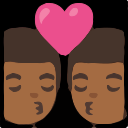

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 26.316446940104168
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 200 
component_num : 31


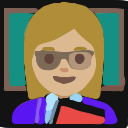

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 72.67909749348958
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 21


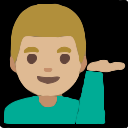

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 25.5546875
128\emoji_u1f4b5.png 
use_bezier_curve_num : 200 
component_num : 14


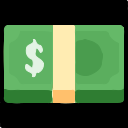

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 23.91888427734375
128\emoji_u1f58a.png 
use_bezier_curve_num : 200 
component_num : 16


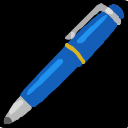

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 12.132283528645834
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 200 
component_num : 23


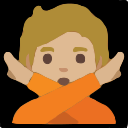

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 23.636881510416668
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 23


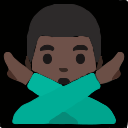

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 25.590718587239582
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 21


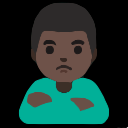

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 20.79498291015625
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 200 
component_num : 19


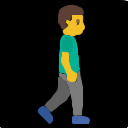

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 7.582661946614583
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 200 
component_num : 23


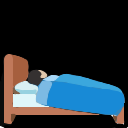

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 9.379414876302084
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 200 
component_num : 15


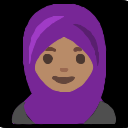

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 32.892171223958336
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 200 
component_num : 33


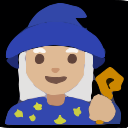

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 26.6055908203125
128\emoji_u1f9ea.png 
use_bezier_curve_num : 200 
component_num : 18


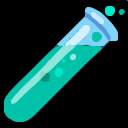

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 7.895975748697917
128 Total MSE: 401.1767374674479
964.4332447052002


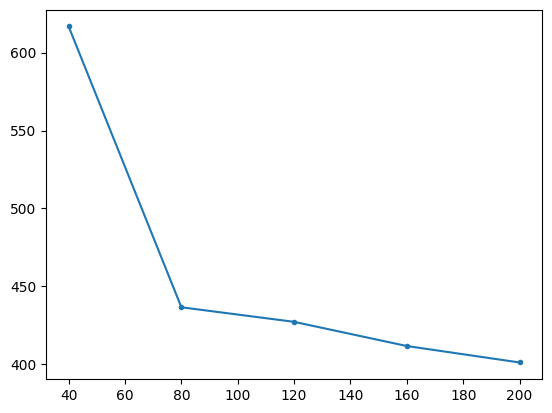

In [93]:
Test(V21=True,V22=True,V23=True,V31=True,labelname="V22&V23")

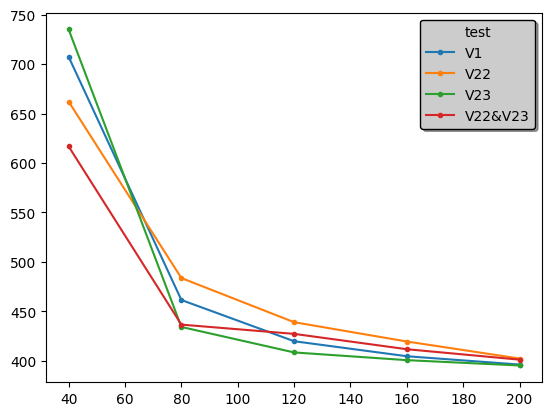

In [99]:
plt.plot(max_bezier_curve_nums,tmsess["V1"],'.-',label="V1")
plt.plot(max_bezier_curve_nums,tmsess["V22"],'.-',label="V22")
plt.plot(max_bezier_curve_nums,tmsess["V23"],'.-',label="V23")
plt.plot(max_bezier_curve_nums,tmsess["V22&V23"],'.-',label="V22&V23")
plt.legend(
    loc='best',
    fontsize=10,
    shadow=True,
    facecolor='#ccc',
    edgecolor='#000',
    title='test',
    title_fontsize=10)